## Motion of double pendulum

![double_pendulum](double_pendulum_scheme.gif)

The system has two degrees of freedom: the displacement angles $\theta_1$ and $\theta_2$.

We have
\begin{align*}
x_1 & = l_1 \sin(\theta_1), \\
y_1 & = -l_1 \cos(\theta_1), \\
x_2 & = l_1 \sin(\theta_1) + l_2 \sin(\theta_2), \\
y_2 & = -l_1 \cos(\theta_1) - l_2 \cos(\theta_2).
\end{align*}

The kinetic energy is
$$
T = \frac{m_1 \dot{x}_1^2}{2} + \frac{m_2 \dot{x}_2^2}{2}
= \frac{1}{2} m_1 l_1^2 \dot{\theta}_1 
+ \frac{1}{2} m_2 \left[ l_1^2 \dot{\theta}_1^2 + l_2^2 \dot{\theta}_2^2 
+ 2 l_1 l_2 \dot{\theta}_1 \dot{\theta_2} \cos(\theta_1 - \theta_2),
\right]
$$
and the potential energy is
$$
V = m_1 g y_1 + m_2 g y_2 = -(m_1+m_2) g l_1 \cos(\theta_1) - m_2 g l_2 \cos(\theta_2).
$$

The Lagrange equations of motion read
\begin{align*}
(m_1 + m_2) l_1 \ddot{\theta}_1 + m_2 l_2 \cos(\theta_1 - \theta_2) \ddot{\theta}_2 & =
-m_2 l_2 \dot{\theta}_2^2 \sin(\theta_1 - \theta_2) - (m_1+m_2) g \sin(\theta_1), \\
m_2 l_1 \cos(\theta_1 - \theta_2) \ddot{\theta}_1  + m_2 l_2 \ddot{\theta}_2 & =
m_2 l_1 \dot{\theta}_1^2 \sin(\theta_1 - \theta_2) - m_2 g \sin(\theta_2).
\end{align*}

This is a system of two linear equations for $ \ddot{\theta}_{1,2}$ that can be solved easily.
Then, all we have to do is denote $\dot{\theta}_{1,2} = \omega_{1,2}$ and solve a system of four first-order ODEs numerically. We will use 4th order Runge-Kutta method with adaptive time step. 

### Prerequisite: RK4 ODE solver with adaptive time step

In [1]:
import numpy as np

def ode_euler_step(f, x, t, h):
    """Perform a single step h using Euler's scheme.

    Args:
    f: the function that defines the ODE.
    x: the value of the dependent variable at the present step.
    t: the present value of the time variable.
    h: the time step

    Returns:
    xnew: the value of the dependent variable at the step t+h
    """
    return x + h * f(x,t)

def ode_rk4_step(f, x, t, h):
    """Perform a single step h using 4th order Runge-Kutta method.

    Args:
    f: the function that defines the ODE.
    x: the value of the dependent variable at the present step.
    t: the present value of the time variable.
    h: the time step

    Returns:
    xnew: the value of the dependent variable at the step t+h
    """
    k1 = h * f(x,t)
    k2 = h * f(x + k1/2., t + h /2.)
    k3 = h * f(x + k2/2., t + h /2.)
    k4 = h * f(x + k3, t + h)
    return x + (k1 + 2. * k2 + 2. * k3 + k4) / 6.

# The default definition of the error (distance) between two state vectors 
# Default: the magnitude of the difference vector
def distance_definition_default(x1, x2):
    diff = x1 - x2
    diffnorm = np.sqrt(np.dot(diff, diff))
    return diffnorm

def ode_rk4_adaptive_multi(f, x0, t0, h0, tmax, delta = 1.e-6, distance_definition = distance_definition_default):
    """Solve an ODE dx/dt = f(x,t) from t = t0 to t = t0 + h*steps 
    using 4th order Runge-Kutta method with adaptive time step.

    Args:
          f: the function that defines the ODE.
         x0: the initial value of the dependent variable.
         t0: the initial value of the time variable.
         h0: the initial time step
       tmax: the maximum time
      delta: the desired accuracy per unit time

    Returns:
    t,x: the pair of arrays corresponding to the time and dependent variables
    """
    
    ts = [t0]
    xs = [x0]
    
    h = h0
    t = t0
    i = 0
        
    while (t < tmax):
        if (t + h >= tmax):
            ts.append(tmax)
            h = tmax - t
            xs.append(ode_rk4_step(f, xs[i], ts[i], h))
            t = tmax
            break
        
        x1 = ode_rk4_step(f, xs[i], ts[i], h)
        x1 = ode_rk4_step(f, x1, ts[i] + h, h)
        x2 = ode_rk4_step(f, xs[i], ts[i], 2*h)
        
        diffnorm = distance_definition(x1, x2)
        if diffnorm == 0.: # To avoid the division by zero
            rho = 2.**4
        else:
            rho = 30. * h * delta / diffnorm
        if rho < 1.:
            h *= rho**(1/4.)
        else:
            if (t + 2.*h) < tmax:
                xs.append(x1)
                ts.append(t + 2*h)
                t += 2*h
            else:
                xs.append(ode_rk4_step(f, xs[i], ts[i], h))
                ts.append(t + h)
                t += h
            i += 1
            h = min(2.*h, h * rho**(1/4.))
        
    return ts,xs

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

## Define all the equations for double pendulum system

We will use parameters $l_1 = l_2 = 0.4$ m and $m_1 = m_2 = 1$ kg.

In [86]:
g  = 9.81 # m/s^2
l1 = 0.4  # m
l2 = 0.4  # m
m1 = 1.0  # kg
m2 = 1.0  # kg

def fdoublependulum(xin, t):
    theta1 = xin[0]
    theta2 = xin[1]
    omega1 = xin[2]
    omega2 = xin[3]
    a1 = (m1 + m2)*l1
    b1 = m2*l2*np.cos(theta1 - theta2)
    c1 = m2*l2*omega2*omega2*np.sin(theta1 - theta2) + (m1 + m2)*g*np.sin(theta1) # + 2.*k*l1*omega1 + k*l2*omega2*np.cos(theta1-theta2)
    a2 = m2*l1*np.cos(theta1 - theta2)
    b2 = m2*l2;
    c2 = -m2*l1*omega1*omega1*np.sin(theta1 - theta2) + m2*g*np.sin(theta2) # + k*l2*omega2 + k*l1*omega1*np.cos(theta1-theta2)
    domega1 = - ( c2/b2 - c1/b1 ) / ( a2/b2 - a1/b1 )
    domega2 = - ( c2/a2 - c1/a1 ) / ( b2/a2 - b1/a1 )
    return np.array([omega1,
                     omega2,
                     domega1,
                     domega2
                    ])

def error_definition_doublependulum(x1, x2):
    return np.abs(np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2))

def kinetic_energy(xin):
    theta1 = xin[0]
    theta2 = xin[1]
    omega1 = xin[2]
    omega2 = xin[3]
    return 0.5 * m1 * l1**2 * omega1**2 + 0.5 * m2 * (l1**2 * omega1**2 + l2**2 * omega2**2 + 2.*l1*l2*omega1*omega2*np.cos(theta1-theta2))

def potential_energy(xin):
    theta1 = xin[0]
    theta2 = xin[1]
    omega1 = xin[2]
    omega2 = xin[3]
    return -m1 * g * l1 * np.cos(theta1) - m2 * g * (l1 * np.cos(theta1) + l2 * np.cos(theta2))

Solve for initial angles $\theta_1^0 = \theta_2^0 = \pi/2$ over time interval of from 0 to 15 seconds

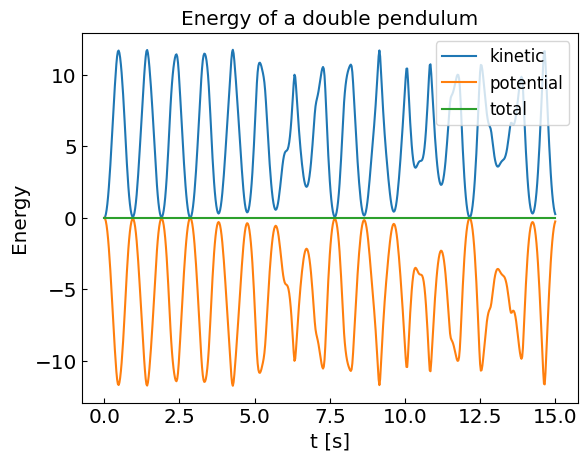

In [117]:
theta1_0 = np.pi / 2.
theta2_0 = np.pi / 2.
omega1_0 = 0.
omega2_0 = 0.
x0 = np.array([theta1_0, theta2_0,omega1_0,omega2_0])

t0 = 0.
tend = 15. # s
cx = x0
eps = 1.e-8

def calcpos1(x):
    return np.array([l1*np.sin(x[0]), -l1*np.cos(x[0])])

def calcpos2(x):
    return np.array([l1*np.sin(x[0]) + l2*np.sin(x[1]), -l1*np.cos(x[0]) - l2*np.cos(x[1])])

ts = [t0]
qs = [x0]
energies = [[kinetic_energy(x0)], [potential_energy(x0)], [kinetic_energy(x0) + potential_energy(x0)]]

fps = 40
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    # rate(fps)
    sol = ode_rk4_adaptive_multi(fdoublependulum, cx, ct, 0.5 * dt, ct+dt, eps, error_definition_doublependulum)
    cx = sol[1][-1]
    
    T = kinetic_energy(cx)
    V = potential_energy(cx)
    ts.append(ct + dt)
    qs.append(cx)
    
    energies[0].append(T)
    energies[1].append(V)
    energies[2].append(T+V)
    
# Plot the energies
plt.plot(ts, energies[0], label = 'kinetic')
plt.plot(ts, energies[1], label = 'potential')
plt.plot(ts, energies[2], label = 'total')
plt.xlabel('t [s]')
plt.ylabel('Energy')
plt.title("Energy of a double pendulum")
plt.legend()
plt.show()

Function to plot the double pendulum at a given time moment

In [118]:
# Visualize
def double_pendulum_plot(cx,ct, axis, labelini = "${\\theta_1^0 = \\theta_2^0 = \pi/2}$", mode = 0):
    axis.set_xlabel("x [cm]")
    axis.set_ylabel("y [cm]")
    if mode == 1:
        axis.set_ylabel("")
        axis.get_yaxis().set_ticklabels([])
        
    axis.set_xlim(-1.1*(l1+l2)*1.e2,1.1*(l1+l2)*1.e2)
    axis.set_ylim(-1.1*(l1+l2)*1.e2,1.1*(l1+l2)*1.e2)
    axis.axhline(y = 0., color = 'black', linestyle = '--')
    # plt.axis('equal')
    axis.set_aspect(1)
    
    axis.text(-0.3*(l1+l2)*1.e2, 0.6*(l1+l2)*1.e2, labelini, fontsize=12)
    
    pos1 = calcpos1(cx) * 1.e2
    pos2 = calcpos2(cx) * 1.e2
    
    axis.plot([pos1[0]],[pos1[1]], 'o', color = 'red',label='mass')
    axis.plot([0.,pos1[0]],[0,pos1[1]], color = 'red',label='rod')
    axis.plot([pos2[0]],[pos2[1]], 'o', color = 'blue',label='mass')
    axis.plot([pos1[0],pos2[0]],[pos1[1],pos2[1]], color = 'blue',label='rod')
    
    # labelrec = "Double pendulum, t = " + "{:.2f}".format(ct) + " s"
    labelrec = "t = " + "{:.2f}".format(ct) + " s"
    axis.set_title(labelrec)

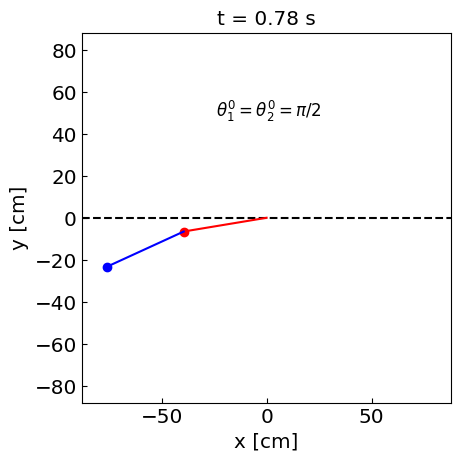

In [119]:
fig, ax = plt.subplots()
ax.clear()
double_pendulum_plot(qs[31], ts[31], ax)

Create animation and save to a gif file

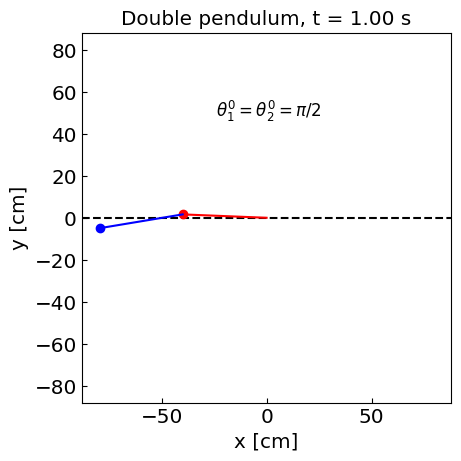

In [49]:
from matplotlib.animation import FuncAnimation

# Enable interactive plot
# %matplotlib notebook

fig, ax = plt.subplots()
# function that draws each frame of the animation
def animate_pendulum(i):
    ax.clear()
    double_pendulum_plot(qs[i], ts[i], ax, "${\\theta_1^0 = \\theta_2^0 = \pi/2}$")
    
ani = FuncAnimation(fig, animate_pendulum, frames=fps * round(tend), interval=1000/fps, repeat=False)
#plt.show()

ani.save("double_pendulum_video_1.gif")

![double_pendulum_2](double_pendulum_video_1.gif)

Simulate another system with slightly different initial angles $\theta_1^0 = \theta_2^0 = \pi/2 + 10^{-4}$

In [120]:
dtheta = 1.e-4
theta1_0 = np.pi / 2. + dtheta
theta2_0 = np.pi / 2. + dtheta
omega1_0 = 0.
omega2_0 = 0.
x0 = np.array([theta1_0, theta2_0,omega1_0,omega2_0])

t0 = 0.
tend = 15. # s
cx = x0
eps = 1.e-8

ts2 = [t0]
qs2 = [x0]

dt = 1./fps
for ct in np.arange(t0, tend, dt):
    # rate(fps)
    sol = ode_rk4_adaptive_multi(fdoublependulum, cx, ct, 0.5 * dt, ct+dt, eps, error_definition_doublependulum)
    cx = sol[1][-1]
    
    T = kinetic_energy(cx)
    V = potential_energy(cx)
    ts2.append(ct + dt)
    qs2.append(cx)
    

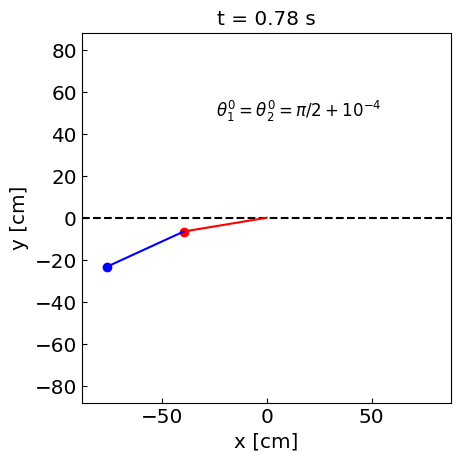

In [121]:
fig, ax = plt.subplots()
ax.clear()
double_pendulum_plot(qs2[31], ts2[31], ax, "${\\theta_1^0 = \\theta_2^0 = \pi/2 + 10^{-4}}$")

Plot the two systems side by side

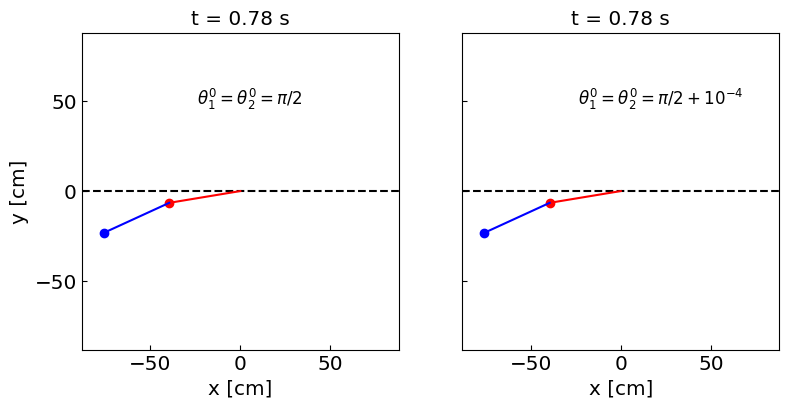

In [122]:
fig, ax = plt.subplots(1, 2)
double_pendulum_plot(qs[31], ts[31], ax[0])
double_pendulum_plot(qs2[31], ts2[31], ax[1], "${\\theta_1^0 = \\theta_2^0 = \pi/2 + 10^{-4}}$", 1)
fig.set_size_inches(9, 5, forward=True)
plt.show()

Create a side-by-side animation

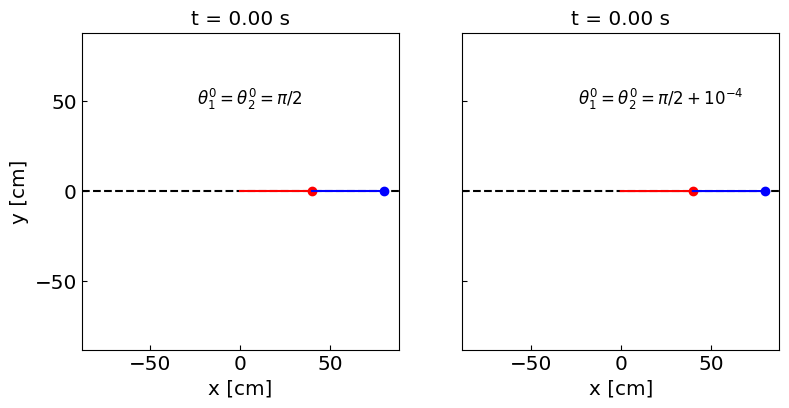

In [123]:
from matplotlib.animation import FuncAnimation

# Enable interactive plot
# %matplotlib notebook

fig, ax = plt.subplots(1, 2)
#double_pendulum_plot_animate(qs[31], ts[31], ax[0])
#double_pendulum_plot_animate(qs2[31], ts2[31], ax[1], "${\\theta_1^0 = \\theta_2^0 = \pi/2 + 10^{-4}}$", 1)
fig.set_size_inches(9, 5, forward=True)
# function that draws each frame of the animation
def animate_pendulum(i):
    ax[0].clear()
    ax[1].clear()
    double_pendulum_plot(qs[i], ts[i], ax[0])
    double_pendulum_plot(qs2[i], ts2[i], ax[1], "${\\theta_1^0 = \\theta_2^0 = \pi/2 + 10^{-4}}$", 1)
    
ani = FuncAnimation(fig, animate_pendulum, frames=fps * round(tend), interval=1000/fps, repeat=False)
#plt.show()

ani.save("double_pendulum_compare.gif")

See the animation

![double_pendulum_compare](double_pendulum_compare.gif)